In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.segmentation import SegmentationMetric
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from importlib import reload
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics
import time
from tqdm.notebook import tqdm

# MXNet ND-Arrays with Numpy notation
#mx.npx.set_np()

# Local Libraries
import pedestrian
import utils
import seg_model

# GPU mode
ctx = mx.gpu()

In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/
reload(pedestrian)

if not os.path.exists(pedestrian.PEDESTRIAN_FILE):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

pedestrian_path = os.getcwd()

# Datasets
pedestrian_train_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="train",
    is_segmentation_task=True,
    invert_masks=False)

pedestrian_val_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="val",
    is_segmentation_task=True,
    invert_masks=False)

pedestrian_test_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="test",
    is_segmentation_task=True,
    invert_masks=False)


# Further pre-processing
# Training pre-processing optimized for speed
# Evaluation pre-processing optimized for visualizations
image_size = 480

imagenet_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

size_transform = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size)
])

train_val_transform = lambda data, output: (imagenet_transform(data), size_transform(output))
test_transform = lambda data, output: (size_transform(data), mx.nd.moveaxis(size_transform(output), -1, 0))

p_train = pedestrian_train_dataset.transform(train_val_transform)
p_val   = pedestrian_val_dataset.transform(train_val_transform)
p_test  = pedestrian_test_dataset.transform(test_transform)

Read 120 images with 307 pedestrians
Read 25 images with 68 pedestrians
Read 25 images with 48 pedestrians


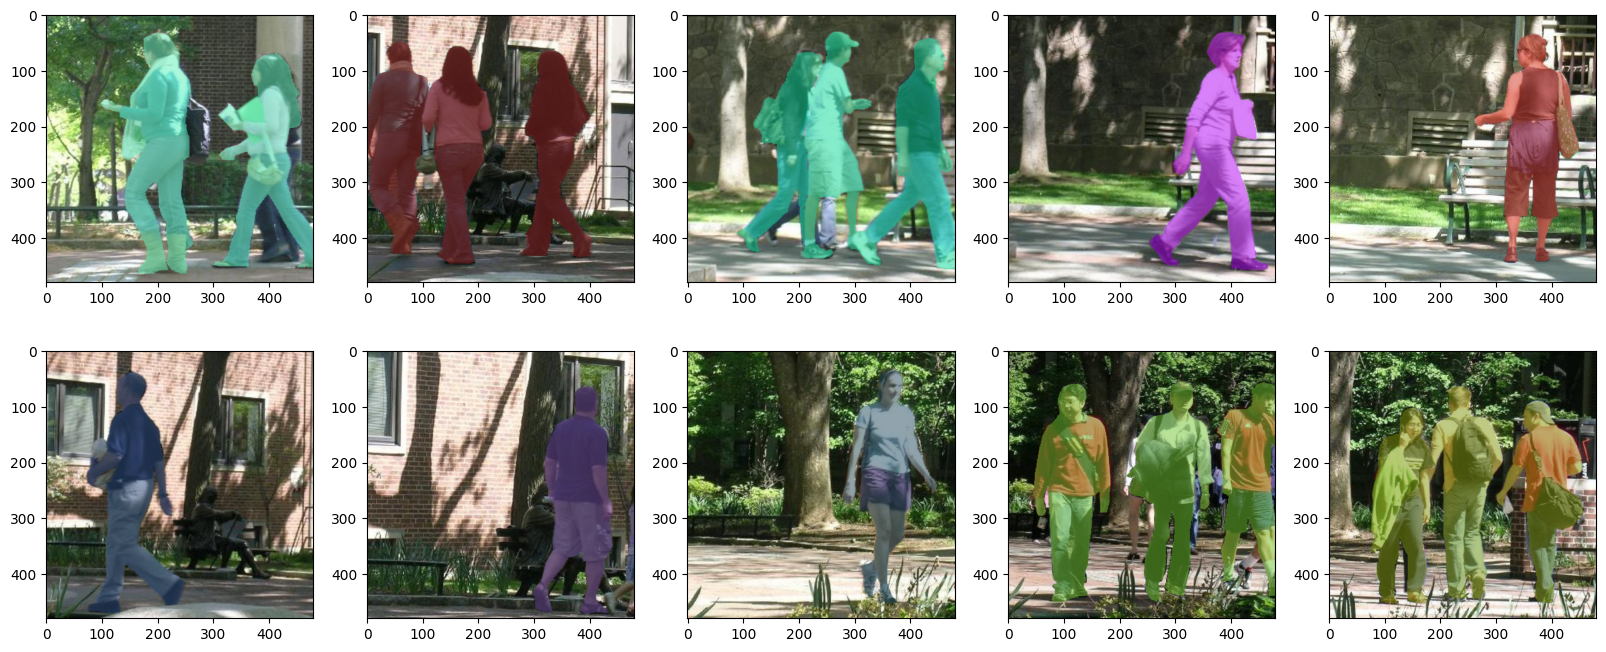

In [4]:
# Display 10 images from the dataset
# 5 x 2 grid
num_images_to_plot = 10
num_columns = 5

fig = plt.figure(figsize=(20, 8))

images_plotted = 0

number_pedestrians = 0

for (X, y) in p_test:
        
    # Format inputs
    image = X
    gt_mask = y

    axes = fig.add_subplot(2, 5, images_plotted + 1)
    masked_image = gcv.utils.viz.plot_mask(image, gt_mask)
    axes.imshow(masked_image)

    images_plotted += 1

    if images_plotted == num_images_to_plot:
        # We are done
        break


In [5]:
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

[20:18:54] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


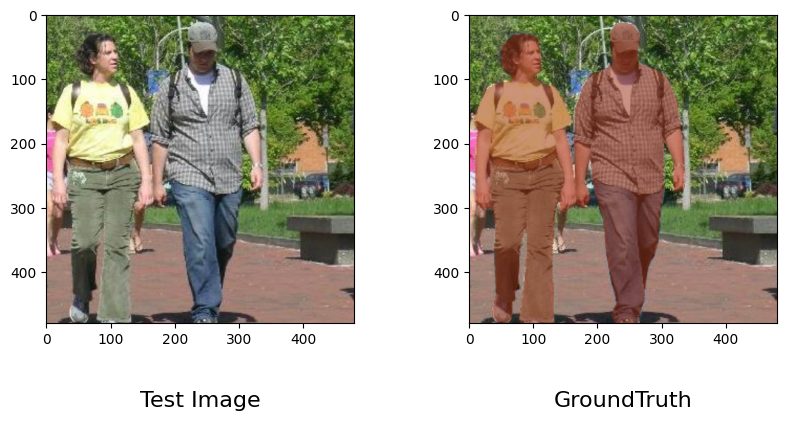

In [8]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("Test Image", fontsize=16, y=-0.3)
axes.imshow(test_image.asnumpy())
axes = fig.add_subplot(1, 2, 2)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.imshow(masked_test_image);

## Training from scratch

In [9]:
ctx = mx.gpu()

# Model
deeplab_ts = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=False, ctx=ctx)

# Replace the last layers for 2 new classes
deeplab_ts.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_ts.head.collect_params().setattr('lr_mult', 10)
deeplab_ts.initialize(ctx=ctx, force_reinit=True)

# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_ts.aux = False
for param in deeplab_ts.auxlayer.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"

model_filename_ts = "deeplab_resnet101_coco_ts.params"

In [10]:
reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 40
batch_size = 2

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_ts.collect_params(), "adam", {"learning_rate": 0.001})

training_loss, validation_loss = seg_model.training_loop(
    deeplab_ts,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train, 
    p_val, 
    model_filename_ts, 
    ctx)

  0%|          | 0/40 [00:00<?, ?it/s]

[20:20:28] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


E:    1, TrL: 1.007670, VL: 10.889924 --- Updating saved model
E:    2, TrL: 0.793036, VL: 1.009523 --- Updating saved model
E:    3, TrL: 0.711834, VL: 0.783043 --- Updating saved model
E:    4, TrL: 0.636039, VL: 0.950161
E:    5, TrL: 0.607631, VL: 0.831024
E:    6, TrL: 0.569892, VL: 0.764744 --- Updating saved model
E:    7, TrL: 0.556131, VL: 0.688453 --- Updating saved model
E:    8, TrL: 0.529602, VL: 0.750275
E:    9, TrL: 0.489679, VL: 0.754299
E:   10, TrL: 0.468919, VL: 0.724724
E:   11, TrL: 0.471194, VL: 0.754288
E:   12, TrL: 0.440964, VL: 0.619939 --- Updating saved model
E:   13, TrL: 0.437711, VL: 1.271493
E:   14, TrL: 0.413103, VL: 0.548542 --- Updating saved model
E:   15, TrL: 0.394558, VL: 0.558978
E:   16, TrL: 0.360238, VL: 0.544858 --- Updating saved model
E:   17, TrL: 0.342477, VL: 0.524285 --- Updating saved model
E:   18, TrL: 0.333156, VL: 0.466624 --- Updating saved model
E:   19, TrL: 0.326500, VL: 0.565458
E:   20, TrL: 0.319382, VL: 0.654130
E:   21, 

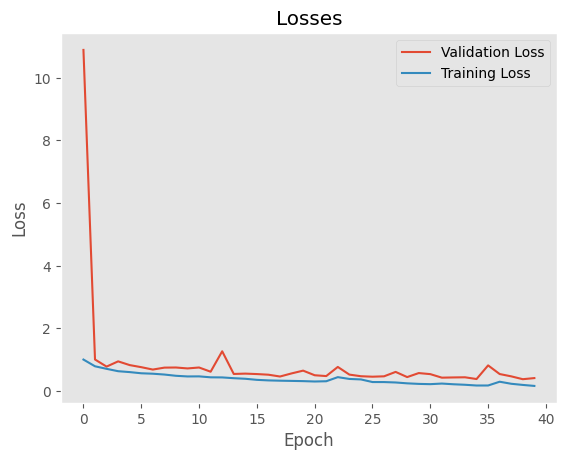

In [11]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [30]:
# Quantitative Evaluation
deeplab_ts.load_parameters(model_filename_ts)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ts(transformed_image)
    print(gt_mask.shape)
    print(output[0].shape)
    segmentation_metrics.update(gt_mask, output[0])
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
(1, 480, 480)
(1, 2, 480, 480)
PixAcc:  0.900821875
mIoU  :  0.7582904329049258


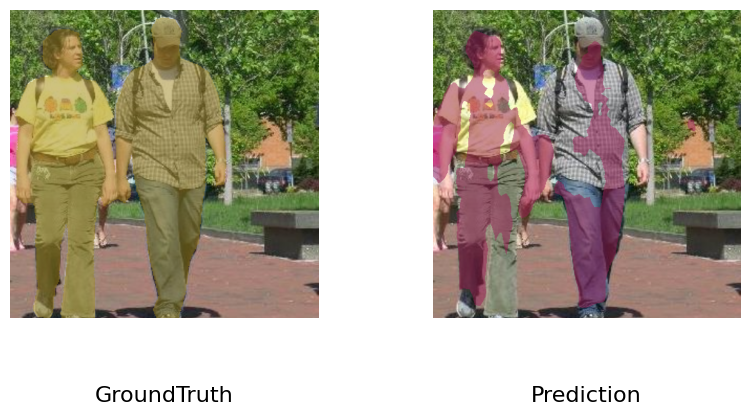

In [13]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ts(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Pre-Trained Model

In [16]:
ctx = mx.gpu()

# DeepLab-v3 from Model Zoo
deeplab_pt = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)
# No additional output needed
deeplab_pt.aux = False

In [26]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_pt(transformed_image)
    filtered_output = pedestrian.PedestrianDataset.process_model_mask(output[0])
    new_filtered_output = filtered_output.copy().expand_dims(1)
    print(gt_mask.shape)
    print(output[0].shape)
    print(filtered_output.shape)
    print(new_filtered_output.shape)
    segmentation_metrics.update(gt_mask, new_filtered_output)
    break
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1, 480, 480)
(1, 480, 480)
(1, 21, 480, 480)
(1

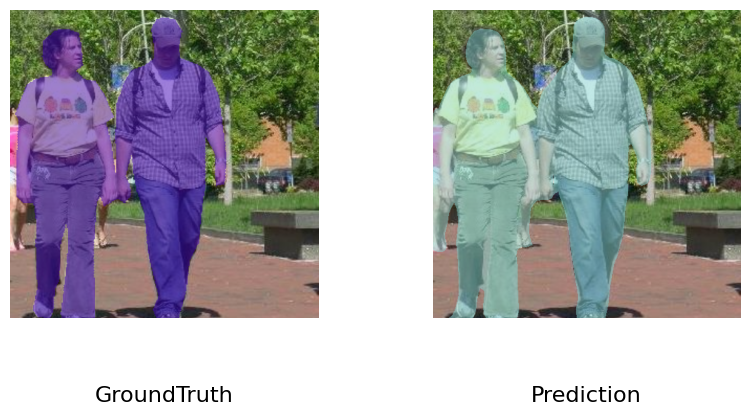

In [22]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_pt(transformed_image)
filtered_output = pedestrian.PedestrianDataset.process_model_mask(output[0])
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Transfer Learning

In [31]:
ctx = mx.gpu()

# Model
deeplab_tl = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)

# Freeze Layers (keeping track of the updated parameters)
updated_params = []
for param in deeplab_tl.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"
        updated_params += [param.name]

# Replace the last layers
deeplab_tl.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_tl.head.initialize(ctx=ctx)
deeplab_tl.head.collect_params().setattr('lr_mult', 10)

# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_tl.aux = False

model_filename_tl = "deeplab_resnet101_coco_tl.params"

In [32]:
reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 20
batch_size = 2

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_tl.collect_params(), "sgd", {"learning_rate": 0.01})

training_loss, validation_loss = seg_model.training_loop(
    deeplab_tl,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train, 
    p_val, 
    model_filename_tl, 
    ctx)

  0%|          | 0/20 [00:00<?, ?it/s]

E:    1, TrL: 0.544273, VL: 0.405036 --- Updating saved model
E:    2, TrL: 0.280111, VL: 0.333441 --- Updating saved model
E:    3, TrL: 0.251274, VL: 0.277721 --- Updating saved model
E:    4, TrL: 0.239988, VL: 0.294183


KeyboardInterrupt: 

In [ ]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Quantitative Evaluation
deeplab_tl.load_parameters(model_filename_tl)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_tl(transformed_image)
    segmentation_metrics.update(gt_mask, output)
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_tl(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Fine-Tuning (after Transfer Learning)

In [ ]:
ctx = mx.gpu()

# Model built on top of Transfer Learning model
deeplab_tl.load_parameters(model_filename_tl)
deeplab_ft = deeplab_tl
# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_ft.aux = False

# Un-freeze weights
for param in deeplab_ft.collect_params().values(): 
    if param.name in updated_params:
        param.grad_req = 'write'

# Except for auxiliary layer weights (not needed)
for param in deeplab_ft.auxlayer.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = 'null'

model_filename_ft = "deeplab_resnet101_coco_ft.params"

In [ ]:
reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 20
batch_size = 2

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_ft.collect_params(), "sgd", {"learning_rate": 0.01})

training_loss, validation_loss = seg_model.training_loop(
    deeplab_ft,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train, 
    p_val, 
    model_filename_ft, 
    ctx)

In [ ]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Quantitative Evaluation
deeplab_ft.load_parameters(model_filename_ft)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft(transformed_image)
    segmentation_metrics.update(gt_mask, output[0])
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ft(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Fine-Tuning (directly)

In [ ]:
ctx = mx.gpu()

# Build on top of Pre-Trained model
deeplab_ft_direct = gcv.model_zoo.get_model("deeplab_resnet101_coco", pretrained=True, ctx=ctx)

# Replace the last layers for 2 new classes
deeplab_ft_direct.head = gcv.model_zoo.deeplabv3._DeepLabHead(2)
deeplab_ft_direct.head.collect_params().setattr('lr_mult', 10)
deeplab_ft_direct.head.initialize(ctx=ctx, force_reinit=True)

# DeepLab v3 has an additional auxiliary output for training/loss
# Not required for our person detector
deeplab_ft_direct.aux = False
for param in deeplab_ft_direct.auxlayer.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"

model_filename_ft_direct = "deeplab_resnet101_coco_ft_direct.params"

In [ ]:
reload(seg_model)

loss_fn = gcv.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
epochs = 20
batch_size = 2

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(deeplab_ft_direct.collect_params(), "sgd", {"learning_rate": 0.01})

training_loss, validation_loss = seg_model.training_loop(
    deeplab_ft_direct,
    loss_fn, 
    trainer, 
    epochs, 
    batch_size, 
    p_train, 
    p_val, 
    model_filename_ft_direct, 
    ctx)

In [ ]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [ ]:
# Quantitative Evaluation
deeplab_ft_direct.load_parameters(model_filename_ft_direct)

segmentation_metrics = SegmentationMetric(nclass=2)

for (X, y) in tqdm(p_test):
    
    # Format inputs
    image = X
    gt_mask = y
    
    transformed_image = gcv.data.transforms.presets.segmentation.test_transform(image, ctx)    
    
    output = deeplab_ft_direct(transformed_image)
    segmentation_metrics.update(gt_mask, output[0])
    
metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

In [ ]:
# Qualitative Evaluation
test_image, test_gt_mask = p_test[24]
transformed_test_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)
output = deeplab_ft_direct(transformed_image)
filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);